In [48]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = { ch:i+1 for i,ch in enumerate(chars) }
stoi['.'] = 0
itos = { i:ch for ch,i in stoi.items() }
vocab_size = len(stoi)

block_size = 3
def build_dataset(words):
    xs = []
    ys = []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:] + [ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [49]:
g = torch.Generator().manual_seed(2147483647)

In [50]:

class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])



In [51]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # Determines whether to calculate and update a running mean and variance during training,
        # or to use the latest values for testing and inference.
        self.training = True
        # Gain
        self.gamma = torch.ones(dim)
        # Bias
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat =  (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
            self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
        

In [52]:
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [105]:
n_embd = 10
n_hidden = 100
vocab_size = 27
block_size = 3

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1 # Keeps logits smaller to prevent large initial loss.
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # This is the alpha value (gain) that encourages the outputs of each layer to remain unit Gaussian.

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
        


47551


In [106]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # Sample a batch of data
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward Pass
    emb = C[Xb]
    x = emb.view(batch_size, -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward Pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break

      0/ 200000: 3.2799


layer 2 (      Tanh): mean -0.00, std  0.63, saturated 2.69%
layer 5 (      Tanh): mean -0.01, std  0.64, saturated 2.31%
layer 8 (      Tanh): mean +0.01, std  0.64, saturated 2.72%
layer 11 (      Tanh): mean -0.01, std  0.64, saturated 2.38%
layer 14 (      Tanh): mean +0.00, std  0.64, saturated 1.97%


Text(0.5, 1.0, 'activation distribution')

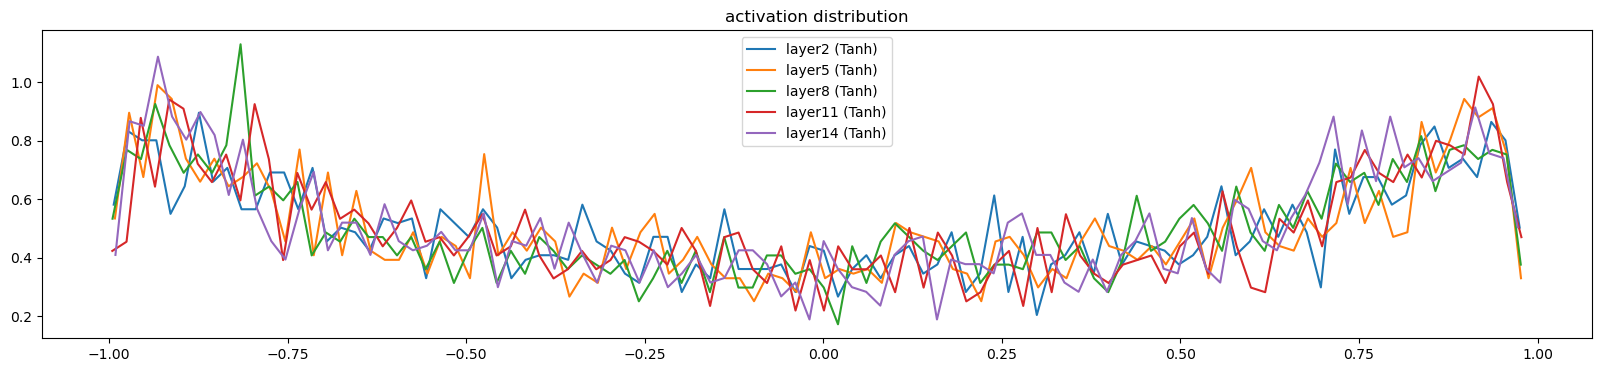

In [107]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std  %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')
        

layer 2 (      Tanh): mean -1.688022e-11, std  4.050643e-03
layer 5 (      Tanh): mean -4.656613e-12, std  3.505978e-03
layer 8 (      Tanh): mean 2.037268e-12, std  3.094589e-03
layer 11 (      Tanh): mean -1.396984e-11, std  2.815047e-03
layer 14 (      Tanh): mean 0.000000e+00, std  2.627393e-03


Text(0.5, 1.0, 'gradient distribution')

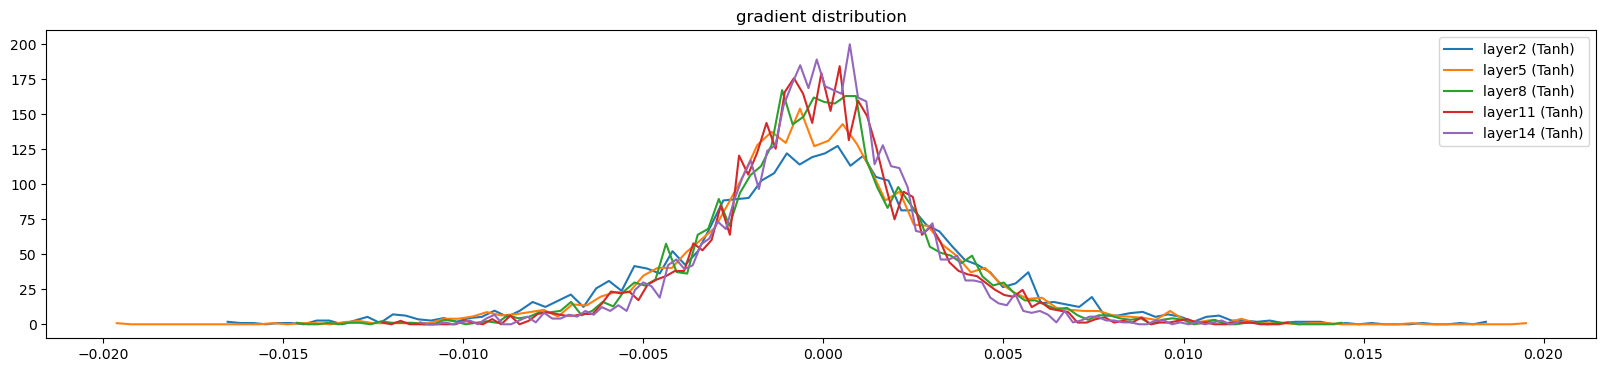

In [108]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %e, std  %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')
 

torch.Size([27, 10])
torch.Size([27, 10])
weight torch.Size([27, 10]) | mean +0.000000 | std  9.495732e-03 | grad:data ratio 9.384339e-03
torch.Size([30, 100])
torch.Size([30, 100])
weight torch.Size([30, 100]) | mean +0.000233 | std  8.393709e-03 | grad:data ratio 2.785733e-02
torch.Size([100, 100])
torch.Size([100, 100])
weight torch.Size([100, 100]) | mean +0.000116 | std  7.411953e-03 | grad:data ratio 4.417057e-02
torch.Size([100, 100])
torch.Size([100, 100])
weight torch.Size([100, 100]) | mean +0.000144 | std  6.442925e-03 | grad:data ratio 3.818673e-02
torch.Size([100, 100])
torch.Size([100, 100])
weight torch.Size([100, 100]) | mean -0.000045 | std  6.109618e-03 | grad:data ratio 3.626243e-02
torch.Size([100, 100])
torch.Size([100, 100])
weight torch.Size([100, 100]) | mean -0.000067 | std  5.576074e-03 | grad:data ratio 3.329415e-02
torch.Size([100, 27])
torch.Size([100, 27])
weight torch.Size([100, 27]) | mean +0.000009 | std  1.087385e-02 | grad:data ratio 6.586904e-02


Text(0.5, 1.0, 'weights gradient distribution')

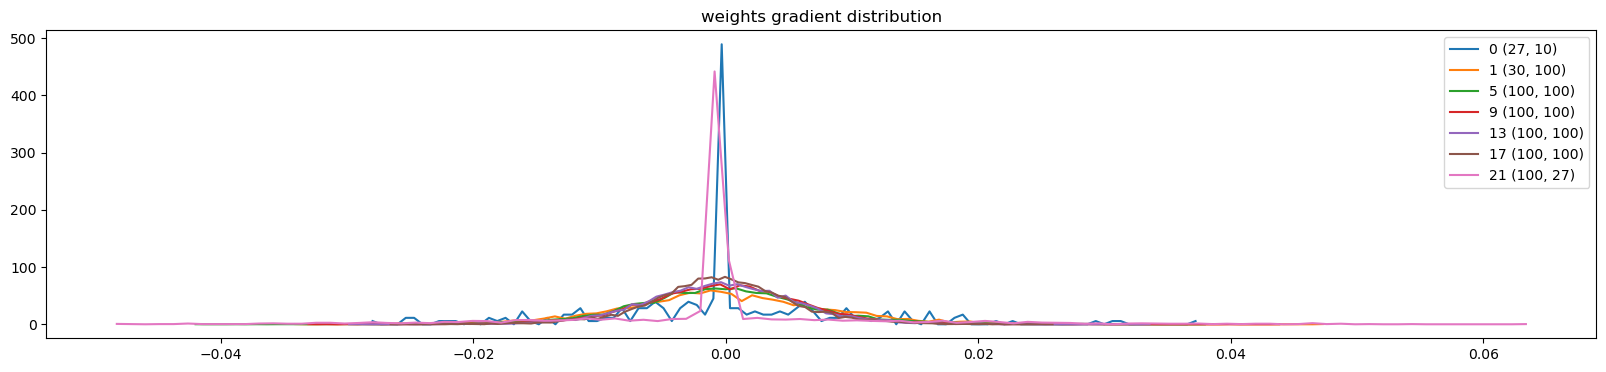

In [109]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(t.shape)
        print(p.data.shape)
        print('weight %10s | mean %+f | std  %e | grad:data ratio %e' % (p.shape, t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')
 

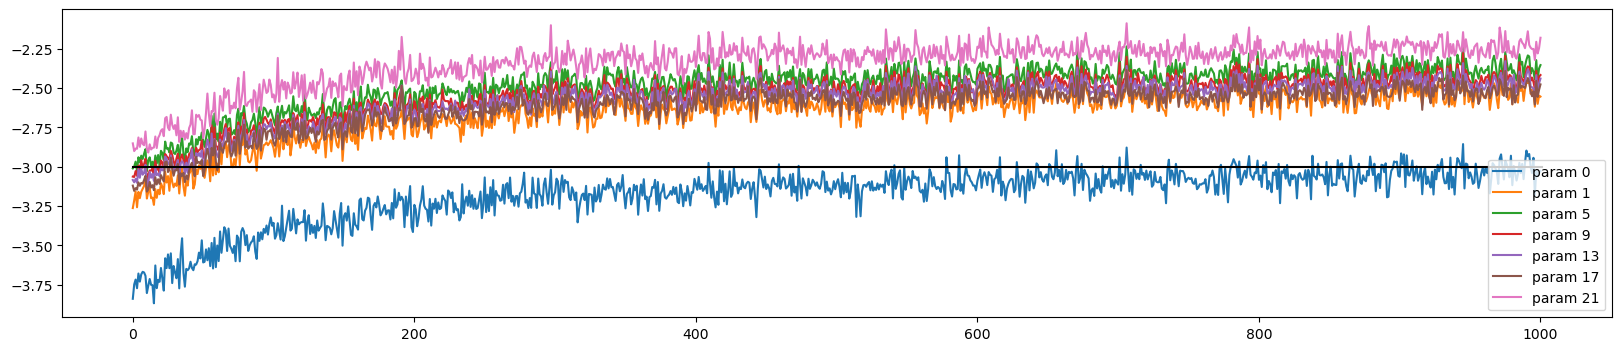

In [110]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)